# Tutorial - Using CRISPRzip

This notebook gives a basic idea how the CRISPRzip model is structured and how it can be used to make predictions about Cas9 activity.


In [2]:
import json

import matplotlib.pyplot as plt

from crisprzip.kinetics import *
from crisprzip.plotting import SearcherPlotter

## 1. Generate R-loop landscapes
### 1.1 Specify protospacer and targets
Let's say you use CRISPR-Cas9 to target the sequence `5'-GACGCATAAAGATGAGACGCTGG-3'` and want to understand its dynamics on the on-target and on some potential off-targets. We specify them below.

In [44]:
guide_rna   =   "GACGCATAAAGATGAGACGC"     # 5'-to-3'
protospacer =  "AGACGCATAAAGATGAGACGCTGG"  # 5'-to-3', with 5' flanking NT (optional) and 3' PAM (NGG)

targets     = [protospacer,                 # on-target
               "AGACCCATTAAGATGAGACGCGGG",  # off-target 1: A13T G17C      (GGG PAM)
               "AGACGCATAACTATGAGACGCAGG",  # off-target 2: G10T A11C      (AGG PAM)
               "AGTCGCATAAAGATGAGACGCGGG",  # off-target 3: A19T           (GGG PAM)
               "AGACGCATAAAGATAAGCGGCCGG"]  # off-target 4: C03G A04C G07A (CGG PAM)

### 1.2 Choose a parameter set (sequence-averaged model)
In CRISPRzip, you simulate the dynamics by constructing an energy landscape of the R-loop formation process. For this, we need to choose a parameter set that contains all the energy contributions. To start, let's use a simpler version of the model that only considers the positions of mismatches and not the sequence content.

In [45]:
# loading a parameter set for the energy landscape model
with open('../../data/landscapes/average_params.json', 'r') as file:
    average_params = json.load(file)

# the Searcher object defines the energy landscapes
protein = Searcher(**average_params)

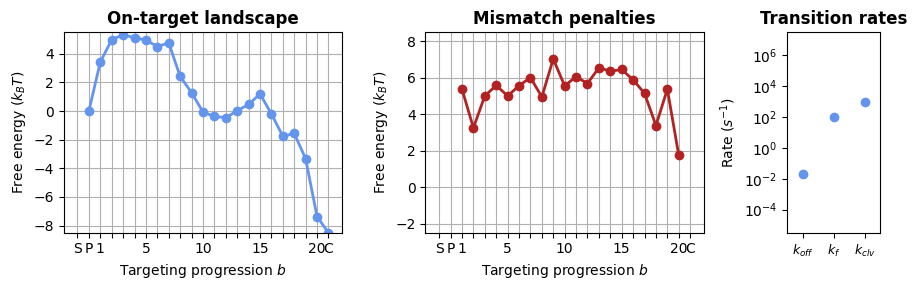

In [46]:
# visualizing the parameter set
_, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

With the above parameter sets, we can construct the energy landscape for any target by adding the appropriate mismatch penalties to the on-target landscape. The ProteinTargetComplex object handles this off-target landscape generations. It also contains functions to calculate Cas9 dynamics on that particular target.

In [47]:
mm_patterns = []
protein_target_complexes = []
for target_seq in targets:
    mm_pattern = (GuideTargetHybrid
                  .from_cas9_offtarget(target_seq, protospacer)
                  .get_mismatch_pattern())
    mm_patterns += [mm_pattern]
    protein_target_complexes += [protein.probe_target(mm_pattern)]

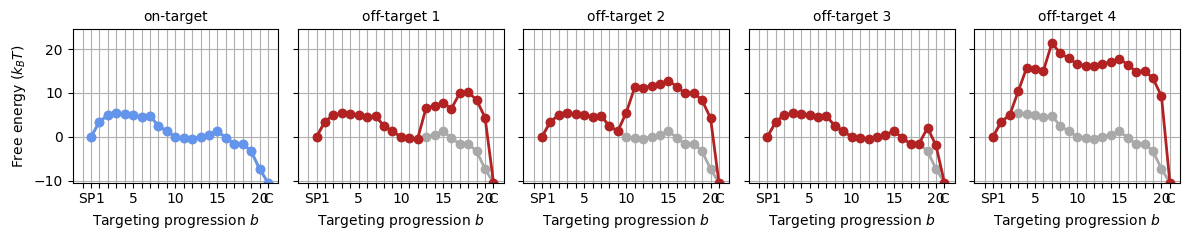

In [53]:
_, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey='all')
for i, mmp in enumerate(mm_patterns):
    SearcherPlotter(protein).plot_off_target_landscape(mmp, axs=axes[i], y_lims=(-10, 24))

    if i == 0:
        axes[i].get_lines()[1].set_color('cornflowerblue')
        axes[i].set_title('on-target', fontsize='medium')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title(f"off-target {i:d}", fontsize='medium')

plt.tight_layout()

### Next steps:
- repeat for sequence model
- show cleavage plot
  - fclv vs time (different concs)
  - kclv vs conc
- show binding plot
  - fbnd vs time (different concs)
  - K vs conc

In [3]:
# loading a parameter set for the energy landscape model
with open('../../data/landscapes/average_params.json', 'r') as file:
    average_params = json.load(file)

protein = Searcher(**bare_protein_params)
guided_protein = bare_protein.bind_guide_rna(protospacer)
protein_target_complexes = [guided_protein.probe_sequence(target_seq)
                            for target_seq in targets]

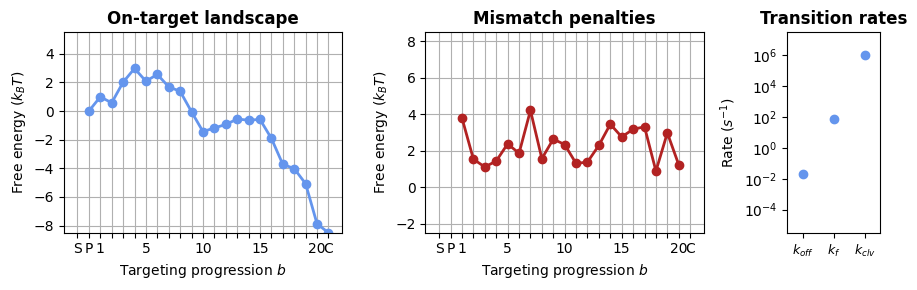

In [6]:
# visualizing the parameter set that defines the energy model
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(bare_protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(bare_protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(bare_protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

## Predicting cleavage rates
With this functionality, a user can predict the probability that a DNA sequence is cleaved. This depends both on concentration and on exposure time, so these parameters could be implemented as an interactive slider. Also, I could calculate the cleavage vs time curve and plot that for an individual or for a few DNA targets.

In [7]:
k_on_ref = 1E-2  # default parameter: k_on at 1 nM (Hz)

# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_clv = [stc.get_cleaved_fraction(time, binding_rate)
         for stc in protein_target_complexes]


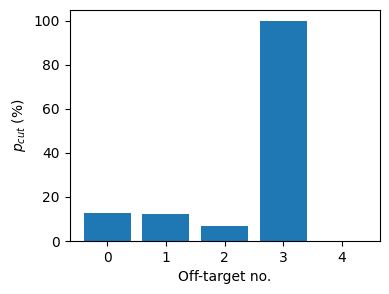

In [8]:
_, axs_clv = plt.subplots(1, 1, figsize=(4, 3))
axs_clv.bar(np.arange(len(protein_target_complexes)),
        np.array(f_clv) * 100, .8)
axs_clv.set_xlabel("Off-target no.")
axs_clv.set_ylabel(r"$p_{cut}$ (%)")
plt.show()

## Predicting binding constants
With this functionality, a user can predict the probability that a DNA sequence is bound. This depends strongly on concentration (and somewhat on exposure time), so these parameters could be implemented as an interactive slider.

In [9]:
# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_bnd = [stc.get_bound_fraction(time, binding_rate)
         for stc in protein_target_complexes]


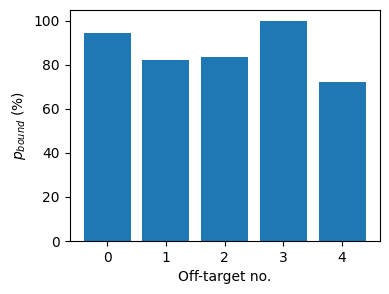

In [10]:
_, axs_bnd = plt.subplots(1, 1, figsize=(4, 3))
axs_bnd.bar(np.arange(len(protein_target_complexes)),
        np.array(f_bnd) * 100, .8)
axs_bnd.set_xlabel("Off-target no.")
axs_bnd.set_ylabel(r"$p_{bound}$ (%)")
plt.show()

## Other
There are a few other features I could add relatively easily:
- Visualizing the energy landscape of a protein-target complex
- Visualizing a coarse-grained version of the full energy landscape
- Generating cleavage and binding curves as a function of time and concentration
- Doing statistics on the cleavage/binding characteristics of the off-target sequences (tables, histograms, etc.)